## Import libraries and load data

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string
import unidecode
import random
import torch

In [29]:
# Check if GPU is available
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

No GPU available, training on CPU; consider making n_epochs very small.


Load the data set

In [30]:
train_df = pd.read_csv('train.csv')
train_df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


Separate EAP from the data

In [31]:
author = train_df[train_df['author'] == 'EAP']["text"]
author.head()

0    This process, however, afforded me no means of...
2    In his left hand was a gold snuff box, from wh...
6    The astronomer, perhaps, at this point, took r...
7          The surcingle hung in ribands from my body.
8    I knew that you could not say to yourself 'ste...
Name: text, dtype: object

Dataset cleaning

In [32]:
text = list(author[:100])
def joinStrings(text):
    return ' '.join(string for string in text)
text = joinStrings(text)
# text = [item for sublist in author[:5].values for item in sublist]
print(len(text.split()))

2802


In [33]:
nltk.download('stopwords')
nltk.download('wordnet')

stop = set(nltk.corpus.stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = nltk.stem.wordnet.WordNetLemmatizer()
def clean(doc):
        stop_free = " ".join([i for i in doc.split() if i not in stop])
        punc_free = "".join(ch for ch in stop_free if ch not in exclude)
        normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
        return normalized
test_sentence = clean(text).lower().split()
test_sentence

[nltk_data] Downloading package stopwords to /Users/sid/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sid/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['this',
 'process',
 'however',
 'afforded',
 'mean',
 'ascertaining',
 'dimension',
 'dungeon',
 'i',
 'might',
 'make',
 'circuit',
 'return',
 'point',
 'whence',
 'i',
 'set',
 'out',
 'without',
 'aware',
 'fact',
 'perfectly',
 'uniform',
 'seemed',
 'wall',
 'in',
 'left',
 'hand',
 'gold',
 'snuff',
 'box',
 'which',
 'capered',
 'hill',
 'cutting',
 'manner',
 'fantastic',
 'step',
 'took',
 'snuff',
 'incessantly',
 'air',
 'greatest',
 'possible',
 'self',
 'satisfaction',
 'the',
 'astronomer',
 'perhaps',
 'point',
 'took',
 'refuge',
 'suggestion',
 'non',
 'luminosity',
 'analogy',
 'suddenly',
 'let',
 'fall',
 'the',
 'surcingle',
 'hung',
 'riband',
 'body',
 'i',
 'knew',
 'could',
 'say',
 'stereotomy',
 'without',
 'brought',
 'think',
 'atomies',
 'thus',
 'theory',
 'epicurus',
 'since',
 'discussed',
 'subject',
 'long',
 'ago',
 'i',
 'mentioned',
 'singularly',
 'yet',
 'little',
 'notice',
 'vague',
 'guess',
 'noble',
 'greek',
 'met',
 'confirmation',
 'la

N-Gram Language Modeling

Recall that in an n-gram language model, given a sequence of words w, we want to compute.

* P(wi|wi−1,wi−2,…,wi−n+1)

* Where wi is the ith word of the sequence. here we will take n=2.

In [34]:
trigrams = [([test_sentence[i], test_sentence[i + 1]], test_sentence[i + 2])
            for i in range(len(test_sentence) - 2)]
chunk_len=len(trigrams)
print(trigrams[:3])

[(['this', 'process'], 'however'), (['process', 'however'], 'afforded'), (['however', 'afforded'], 'mean')]


In [35]:
vocab = set(test_sentence)
voc_len=len(vocab)
vocab

{'disbelief',
 'superstition',
 'ourselves',
 'blackguard',
 'uniform',
 'loop',
 'bulk',
 'met',
 'brass',
 'got',
 'scarabæus',
 'fellow',
 'speculation',
 'summed',
 'but',
 'hanging',
 'there',
 'add',
 'aim',
 'cavity',
 'number',
 'sounding',
 'interspersed',
 'thing',
 'ho',
 'foot',
 'peculiar',
 'excellent',
 'smith',
 'me',
 'another',
 'moreover',
 'wont',
 'effected',
 'struck',
 'sentiment',
 'end',
 'least',
 'fro',
 'ransacking',
 'thrust',
 'needle',
 'fired',
 'dxnt',
 'haste',
 'contraction',
 'adjust',
 'rested',
 'draconian',
 'exists',
 'greater',
 'supreme',
 'aspect',
 'remembered',
 'pirate',
 'influence',
 'submitted',
 'glorious',
 'astronomer',
 'loud',
 'crossed',
 'presently',
 'whole',
 'stereotomy',
 'hurried',
 'powdered',
 'pallor',
 'exceeding',
 'continuous',
 'moment',
 'get',
 'fairly',
 'beg',
 'pause',
 'recovered',
 'kempelens',
 'wit',
 'laid',
 'incessantly',
 'profusion',
 'looking',
 'alexander',
 'manner',
 'many',
 'artist',
 'game',
 'vibr

In [36]:
word_to_ix = {word: i for i, word in enumerate(vocab)}
word_to_ix

{'disbelief': 0,
 'superstition': 1,
 'ourselves': 2,
 'blackguard': 3,
 'uniform': 4,
 'loop': 5,
 'bulk': 6,
 'met': 7,
 'brass': 8,
 'got': 9,
 'scarabæus': 10,
 'fellow': 11,
 'speculation': 12,
 'summed': 13,
 'but': 14,
 'hanging': 15,
 'there': 16,
 'add': 17,
 'aim': 18,
 'cavity': 19,
 'number': 20,
 'sounding': 21,
 'interspersed': 22,
 'thing': 23,
 'ho': 24,
 'foot': 25,
 'peculiar': 26,
 'excellent': 27,
 'smith': 28,
 'me': 29,
 'another': 30,
 'moreover': 31,
 'wont': 32,
 'effected': 33,
 'struck': 34,
 'sentiment': 35,
 'end': 36,
 'least': 37,
 'fro': 38,
 'ransacking': 39,
 'thrust': 40,
 'needle': 41,
 'fired': 42,
 'dxnt': 43,
 'haste': 44,
 'contraction': 45,
 'adjust': 46,
 'rested': 47,
 'draconian': 48,
 'exists': 49,
 'greater': 50,
 'supreme': 51,
 'aspect': 52,
 'remembered': 53,
 'pirate': 54,
 'influence': 55,
 'submitted': 56,
 'glorious': 57,
 'astronomer': 58,
 'loud': 59,
 'crossed': 60,
 'presently': 61,
 'whole': 62,
 'stereotomy': 63,
 'hurried': 64

In [37]:
inp=[]
tar=[]
for context, target in trigrams:
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
        inp.append(context_idxs)
        targ = torch.tensor([word_to_ix[target]], dtype=torch.long)
        tar.append(targ)

GRU model for Text Generation

In [38]:
import torch
import torch.nn as nn
from torch.autograd import Variable

In [39]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size*2, hidden_size, n_layers,batch_first=True,
                          bidirectional=False)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [40]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0
    
    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c])

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / chunk_len

In [41]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [42]:
n_epochs = 300
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.015

decoder = RNN(voc_len, hidden_size, voc_len, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [43]:
start = time.time()
all_losses = []
loss_avg = 0
if(train_on_gpu):
    decoder.cuda()
for epoch in range(1, n_epochs + 1):
    loss = train(inp,tar)       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 50, loss))
#         print(evaluate('ge', 200), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

KeyboardInterrupt: 

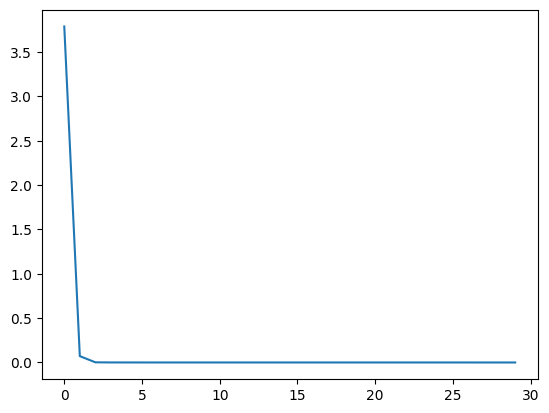

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

Generating the text

In [ ]:
def evaluate(prime_str='this process', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()

    for p in range(predict_len):
        
        prime_input = torch.tensor([word_to_ix[w] for w in prime_str.split()], dtype=torch.long)
        inp = prime_input[-2:] #last two words as input
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted word to string and use as next input
        predicted_word = list(word_to_ix.keys())[list(word_to_ix.values()).index(top_i)]
        prime_str += " " + predicted_word
#         inp = torch.tensor(word_to_ix[predicted_word], dtype=torch.long)

    return prime_str

In [ ]:
print(evaluate('this process', 40, temperature=1))

this process however afforded mean ascertaining dimension dungeon i might make circuit return point whence i set out without aware fact perfectly uniform seemed wall in left hand gold snuff box which capered hill cutting manner fantastic step took snuff incessantly air


In [ ]:
print(evaluate('i might', 30, temperature=1))

i might make circuit return point whence i set out without aware fact perfectly uniform seemed wall in left hand gold snuff box which capered hill cutting manner fantastic step took snuff


In [ ]:
print(evaluate('the matter', 30, temperature=1))

the matter provided generally room room the latter examined carefully deposited pocket book then unlocking escritoire took thence letter gave prefect xh pxh pxh jxhn dxnt dx sx yxuve gxt tx gx


Test

In [ ]:
word_to_ix = {word: i for i, word in enumerate(vocab)}
word_to_ix

{'disbelief': 0,
 'superstition': 1,
 'ourselves': 2,
 'blackguard': 3,
 'uniform': 4,
 'loop': 5,
 'bulk': 6,
 'met': 7,
 'brass': 8,
 'got': 9,
 'scarabæus': 10,
 'fellow': 11,
 'speculation': 12,
 'summed': 13,
 'but': 14,
 'hanging': 15,
 'there': 16,
 'add': 17,
 'aim': 18,
 'cavity': 19,
 'number': 20,
 'sounding': 21,
 'interspersed': 22,
 'thing': 23,
 'ho': 24,
 'foot': 25,
 'peculiar': 26,
 'excellent': 27,
 'smith': 28,
 'me': 29,
 'another': 30,
 'moreover': 31,
 'wont': 32,
 'effected': 33,
 'struck': 34,
 'sentiment': 35,
 'end': 36,
 'least': 37,
 'fro': 38,
 'ransacking': 39,
 'thrust': 40,
 'needle': 41,
 'fired': 42,
 'dxnt': 43,
 'haste': 44,
 'contraction': 45,
 'adjust': 46,
 'rested': 47,
 'draconian': 48,
 'exists': 49,
 'greater': 50,
 'supreme': 51,
 'aspect': 52,
 'remembered': 53,
 'pirate': 54,
 'influence': 55,
 'submitted': 56,
 'glorious': 57,
 'astronomer': 58,
 'loud': 59,
 'crossed': 60,
 'presently': 61,
 'whole': 62,
 'stereotomy': 63,
 'hurried': 64

In [ ]:
print(evaluate('the matter', 30, temperature=1))

the matter late haste visage slxw air given soon must would scarabæus writer susceptibility perplexity fancying notice the prince provided appliance pleasure he comprehended moreover true character august aim supreme majesty dignity
